In [4]:
import mplsoccer as mpl
from highlight_text import ax_text
import warnings
from PIL import Image
from urllib.request import urlopen

from variables import player_iden, player_nn, cur_team, comp_name, player_number

In [5]:
match_id = 3837876

In [6]:
parser = mpl.Sbopen()
df_event, df_related, df_freeze, df_tactics = parser.event(match_id)
df_lineup = parser.lineup(match_id)

In [7]:
team2 = list(set(df_event.team_name.unique()) - {cur_team})[0]

In [8]:
shots = df_event[(df_event['type_name'] == "Shot") &
               (df_event['player_id'] == player_iden) &
               (df_event['sub_type_name'] != 'Penalty') &
               (df_event['period'] < 5)]

In [9]:
shots_id_arr = [shots.id.iloc[i] for i in range(len(shots.id))]
shots_id_arr

['60adf300-daba-4eda-a6c9-d35103f4aed7',
 'cf94135a-c6c9-4482-8986-edab48aab0de']

In [10]:
goals = shots[shots['outcome_name'] == 'Goal']
goals_id_arr = [goals.id.iloc[i] for i in range(len(goals.id))]
goals_id_arr

['cf94135a-c6c9-4482-8986-edab48aab0de']

In [11]:
positions_during_game = ', '.join(set(df_tactics[df_tactics.player_id == player_iden].position_name))

In [12]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [13]:
PSG_LOGO = ('https://upload.wikimedia.org/wikipedia/ru/thumb/a/a7/Paris_Saint-Germain_F.C..svg/1024px-Paris_Saint-Germain_F.C..svg.png')

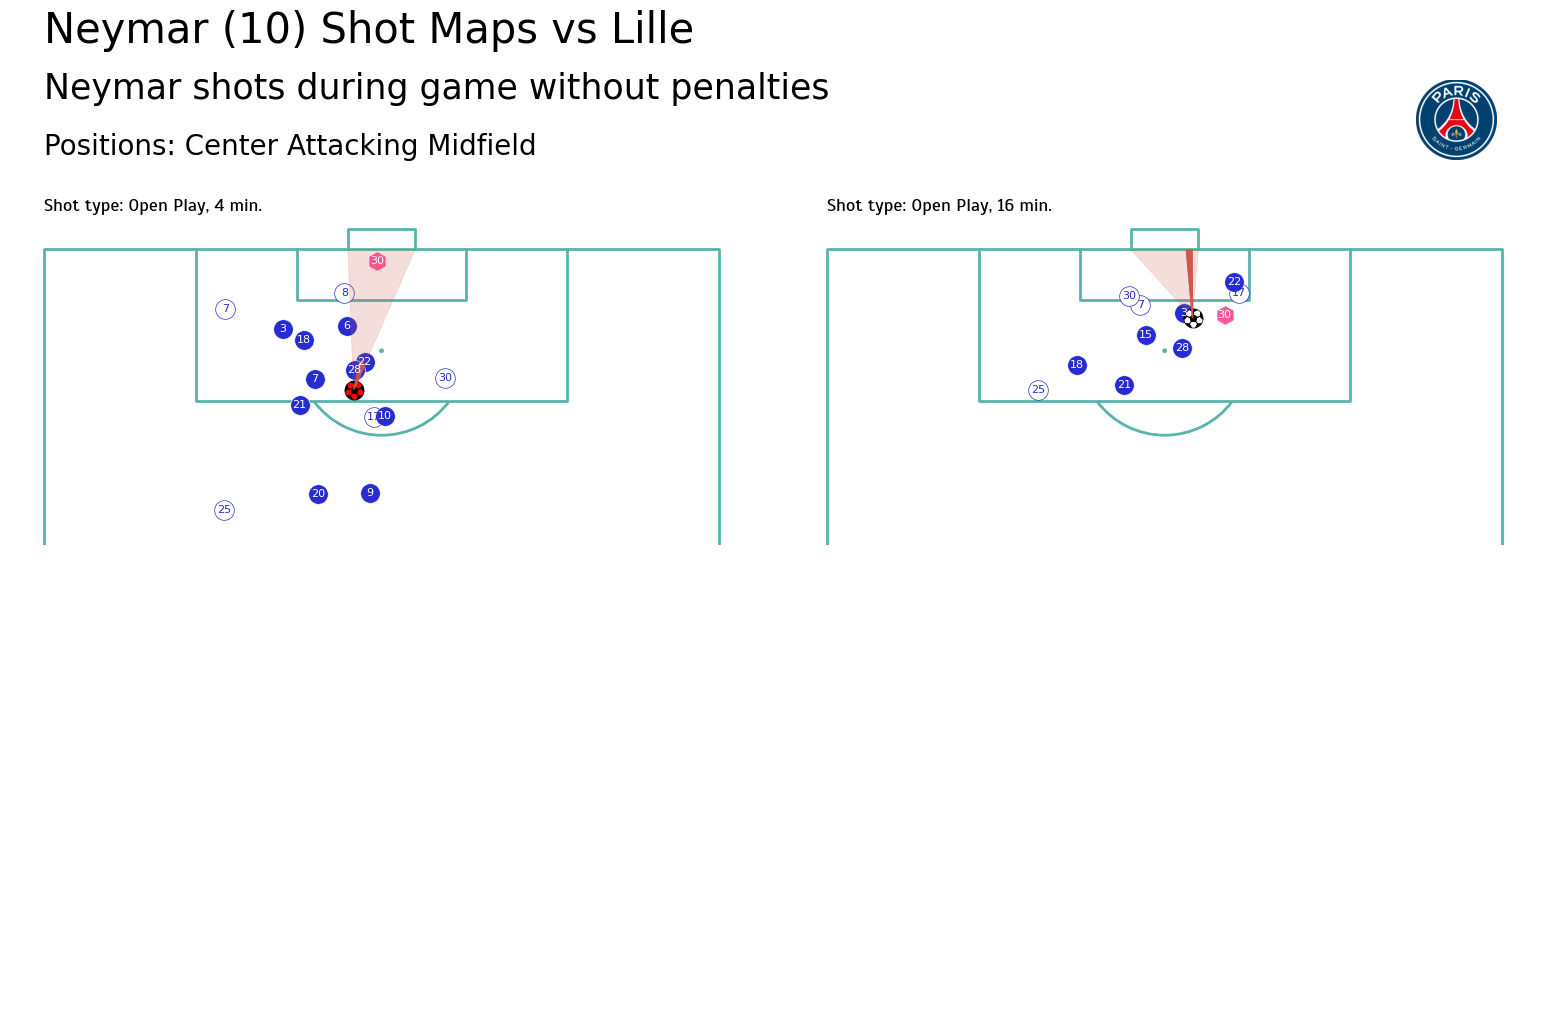

In [15]:
pitch = mpl.VerticalPitch(pad_top=10, half=True, goal_type='box', pad_bottom=-25, pitch_color='white', line_color='#58b3aa', linewidth=2)

fig, axs = pitch.grid(nrows=2, ncols=2, figheight=10,
                      endnote_height=0.04, endnote_space=0,
                      axis=False, #True,
                      title_height=0.14, grid_height=0.80)

player_symbol_size = 200

goal_legend = []
other_legend = []

for idx, ax in enumerate(axs['pitch'].flat):
  if idx < len(shots_id_arr):
    SHOT_ID = shots_id_arr[idx]
    df_freeze_frame = df_freeze[df_freeze.id == SHOT_ID].copy()
    df_shot_event = df_event[df_event.id == SHOT_ID].dropna(axis=1, how='all').copy()

    # add the jersey number
    df_freeze_frame = df_freeze_frame.merge(df_lineup, how='left', on='player_id')
    # strings for team names
    team1 = df_shot_event.team_name.iloc[0]
    team2 = list(set(df_event.team_name.unique()) - {team1})[0]

    # subset the team shooting, and the opposition (goalkeeper/ other)
    df_team1 = df_freeze_frame[df_freeze_frame.team_name == team1]
    df_team2_goal = df_freeze_frame[(df_freeze_frame.team_name == team2) &
                                    (df_freeze_frame.position_name == 'Goalkeeper')]
    df_team2_other = df_freeze_frame[(df_freeze_frame.team_name == team2) &
                                    (df_freeze_frame.position_name != 'Goalkeeper')]

    c = 'red' if SHOT_ID not in goals_id_arr else 'white'
    shooter_label = 'Shooter (not scored)' if SHOT_ID not in goals_id_arr else 'Shooter (scored)'

    # Plot the players
    sc1_att = pitch.scatter(df_team1.x, df_team1.y, s=player_symbol_size, c='white', label='Attacker', ax=ax, edgecolors='#262cd1')
    sc2_def = pitch.scatter(df_team2_other.x, df_team2_other.y, s=player_symbol_size, c='#262cd1', label='Defender', ax=ax, edgecolors='white')
    sc4_glk = pitch.scatter(df_team2_goal.x, df_team2_goal.y, s=player_symbol_size, ax=ax, c='#ff569e', label='Goalkeeper', marker='h', edgecolors='white')

    # plot the shot
    sc3 = pitch.scatter(df_shot_event.x, df_shot_event.y, marker='football', s=player_symbol_size, ax=ax, label=shooter_label, zorder=1.2, c = c)

    line = pitch.lines(df_shot_event.x, df_shot_event.y, df_shot_event.end_x, df_shot_event.end_y, comet=True, label='Shot', color='#cb5a4c', ax=ax)

    # plot the angle to the goal
    pitch.goal_angle(df_shot_event.x, df_shot_event.y, ax=ax, alpha=0.2, zorder=1.1,
                    color='#cb5a4c', goal='right')

    # plot the jersey numbers TEAM1
    for i, label in enumerate(df_freeze_frame.jersey_number):
        num_col = '#262cd1' if df_freeze_frame.team_name[i] == team1 else 'white'
        pitch.annotate(label, (df_freeze_frame.x[i], df_freeze_frame.y[i]),
                      va='center', ha='center', color=num_col, fontsize=8, ax=ax)

    annotation_string = (f'Shot type: {shots.sub_type_name.iloc[idx]}, {shots.minute.iloc[idx]} min.')
    ax_text(0, 125, annotation_string, ha='left', va='center', fontsize=13,
                fontproperties=fm_scada.prop,  # using the fontmanager for the google font
                ax=ax, color='black')

# remove unused axes (if any)
for ax in axs['pitch'].flat[len(shots_id_arr):]:
    ax.remove()

# title text
axs['title'].text(0, 0.8, f'{player_nn} ({player_number}) Shot Maps vs {team2}', fontsize=30, va='baseline', ha='left')
SUB_TEXT = (f'{player_nn} shots during game without penalties')
axs['title'].text(0, 0.4, SUB_TEXT, fontsize=25, va='baseline', ha='left')
axs['title'].text(0, 0, f'Positions: {positions_during_game}', fontsize=20, va='baseline', ha='left')

image = Image.open(urlopen(PSG_LOGO))
set_image = mpl.add_image(image, fig, left=0.9, bottom=0.85, width=0.05, interpolation='hanning')